<a href="https://colab.research.google.com/github/ganeshbmc/MLP/blob/main/colabs_mlp/wk7_knn_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-nearest neighbors classifier  

## Imports  

In [ ]:
# Common imports
import numpy as np
from pprint import pprint

# to make this notebook's output stable across runs
np.random.seed(42)

# sklearn specific imports
# Data fetching  
from sklearn.datasets import fetch_openml

# Features scaling
from sklearn.preprocessing import MinMaxScaler

# pca
from sklearn.decomposition import PCA

# Pipeline utility
from sklearn.pipeline import make_pipeline

# Classifier: dummy, KNN
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

# Model selection
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.model_selection import learning_curve

# Evaluation metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# global settings
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', figsize=(8,6))

## Handwritten Digit classification  


Load MNIST dataset for handwritten digit recognition from OpenML  

In [ ]:
X, y = fetch_openml('mnist_784', return_X_y=True)
X = X.to_numpy()
y = y.to_numpy()

In [ ]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary classification  

## Change labels to binary  

* Let's do binary classification with KNN classifier and eventually extend it to multiclass set-up  

In [ ]:
# initialize new variable names with all -1
y_train_0 = -1*np.ones(len(y_train))
y_test_0 = -1*np.ones(len(y_test))

# find indices where digit 0 image
# Note: Labels in MNIST dataset are of string datatype
indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

## Date visualization in lower dimension  

* Let us apply PCA on the datapoints and reduce the dimensions to 2D and then to 3D  
* This will give us some rough idea about the points in R^784  
* One interesting thing to look at is the change in magnitude of the datapoints before and after applying PCA.  
* We use the variables `pipe_pca_2d` for pre-processing the samples alone and `pipe_clf_pca_2d` for classification.  

In [ ]:
pipe_pca_2d = make_pipeline(MinMaxScaler(), PCA(n_components=2))
x_train_pca_2d = pipe_pca_2d.fit_transform(x_train)

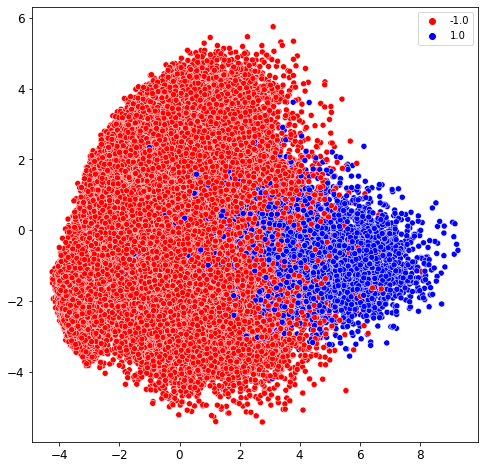

In [ ]:
cmap = mpl.colors.ListedColormap(['r', 'b'])
plt.figure(figsize=(8,8))
sns.scatterplot(x=x_train_pca_2d[:, 0], y=x_train_pca_2d[:, 1], hue=y_train_0, palette=cmap)
plt.show()

In [ ]:
pipe_pca_3d = make_pipeline(MinMaxScaler(), PCA(n_components=3))
x_train_pca_3d = pipe_pca_3d.fit_transform(x_train)

In [ ]:
import plotly.express as px
fig = px.scatter_3d(x=x_train_pca_3d[:,0],
                    y=x_train_pca_3d[:,1],
                    z=x_train_pca_3d[:,2],
                    color=y_train_0,
                    color_discrete_map=cmap,
                    opacity=0.5)
fig.show()

ModuleNotFoundError: No module named 'plotly'

## KNN classifier  

Algorithm ([video link](https://youtu.be/nbOcdzyPulA?t=192)  )

In [ ]:
# creating a new pipeline for classifier  
pipe_clf_pca_2d = make_pipeline(pipe_pca_2d, KNeighborsClassifier(n_neighbors=3))

* Let us train the model with 10 samples from training set (i.e., we are just putting 10 datapoints in the metric space, not building any parametrized model).  
* Then test the model with 10 datapoints from test set.  

In [ ]:
index_neg = np.argsort(y_train_0)[:5]   # index of negative samples
index_pos = np.argsort(y_train_0)[-1:-6:-1] # index of positive samples

Sanity check  

In [ ]:
# ensure first 10 samples are mix of both classes  
print(f'Pos_classes: {y_train_0[index_pos]}')
print(f'Neg_classes: {y_train_0[index_neg]}')

Pos_classes: [1. 1. 1. 1. 1.]
Neg_classes: [-1. -1. -1. -1. -1.]


In [ ]:
# create a small dataset
x = np.vstack((x_train[index_pos, :], x_train[index_neg, :]))
print(x.shape)
y = np.hstack((y_train_0[index_pos], y_train_0[index_neg]))
print(y.shape)

(10, 784)
(10,)


In [ ]:
# Let us fit the model with new training set
pipe_clf_pca_2d.fit(x,y)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                 ('pca', PCA(n_components=2))])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

In [ ]:
# for visualization
x_reduced = pipe_clf_pca_2d[0].transform(x)

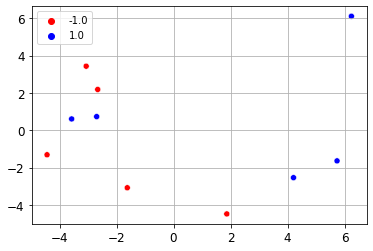

In [ ]:
cmap = mpl.colors.ListedColormap(['r', 'b'])
plt.figure(figsize=(6,4))
sns.scatterplot(x=x_reduced[:,0], y=x_reduced[:,1], markers='o', hue=y, palette=cmap)
plt.grid(True)
plt.show()

Test labels: [-1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]


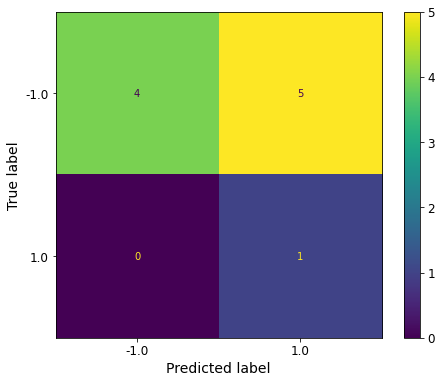

In [ ]:
y_hat_0 = pipe_clf_pca_2d.predict(x_test[:10, :])
print('Test labels:', y_test_0[:10])
ConfusionMatrixDisplay.from_predictions(y_test_0[:10], y_hat_0)
plt.show()
# Needs sklearn version 1.0; currently installed is sklearn version 0.24.2

* We can see that there are more FP's (since 9 out of 10 actual labels are negative)  
* Let us display both the training points and testing points with their predictions  
* We can visually validate the reason behind the performance.  

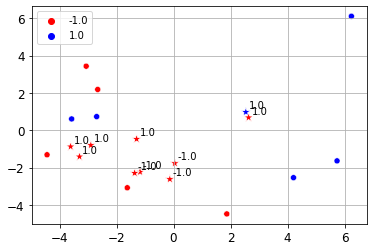

In [ ]:
cmap = mpl.colors.ListedColormap(['r', 'b'])
plt.figure(figsize=(6,4))
sns.scatterplot(x=x_reduced[:,0], y=x_reduced[:,1], markers='o', hue=y, palette=cmap)

# test points
x_test_reduced = pipe_clf_pca_2d[0].transform(x_test[:10, :])
sns.scatterplot(x=x_test_reduced[:,0],y=x_test_reduced[:,1], s=100, marker='*', hue=y_test_0[:10], palette=cmap, legend=None)

# plot the test points and annotate the points with their predictions
dx, dy = 0.1,0.2
for i in range(10):
    plt.annotate(str(y_hat_0[i]), xy=(x_test_reduced[i,0]+dx, x_test_reduced[i,1]+dy))

# show grid
plt.grid(True)
plt.show()

* It woould be much better if we know the distance of 3 neighbors for each testing point.  
* Let us display the distance and connectivity of neighbours to the test datapoints(s) using the class `NearestNeighbors`.  
* In fact, `KneighboursClassifier` calls `NearestNeighbors` class internally to compute all the distances.  

In [ ]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=3)
neighbors.fit(pipe_pca_2d.transform(x))

NearestNeighbors(n_neighbors=3)

Which are the first three closest neighbors of the first three in the test set? and how close are they?

In [ ]:
dist_neighbors, idx_neighbors = neighbors.kneighbors(pipe_pca_2d.transform(x_test[:10]),
                                                    3,
                                                    return_distance=True)

In [ ]:
import statistics

for i in range(3):
    print("distance:{0}, \nIndex:{1}, \nLabels:{2}, \nPredictions:{3}".format(dist_neighbors[i],
                                                                                idx_neighbors[i],
                                                                                y[idx_neighbors[i].flatten()],
                                                                                statistics.mode(y[idx_neighbors[i].flatten()])))

distance:[1.54510433 1.56004731 1.61914472], 
Index:[1 4 6], 
Labels:[ 1.  1. -1.], 
Predictions:1.0
distance:[0.95703587 3.33077652 3.39001596], 
Index:[7 1 6], 
Labels:[-1.  1. -1.], 
Predictions:-1.0
distance:[1.14297879 2.0379748  2.22709669], 
Index:[6 4 1], 
Labels:[-1.  1.  1.], 
Predictions:1.0


Let us train the model with 10000 samples from training set (i.e., we are just plotting 10000 datapoints in the metric space, not building any parametrized model)

In [ ]:
pipe_clf_pca_2d.fit(x_train[:10000], y_train_0[:10000])

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                 ('pca', PCA(n_components=2))])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

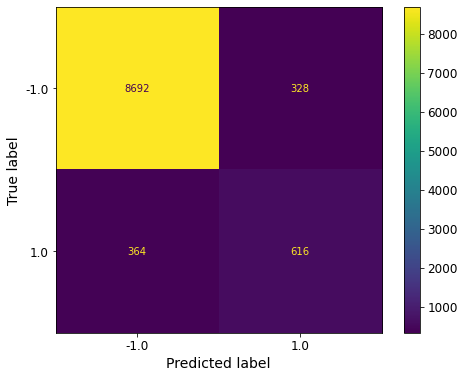

In [ ]:
y_hat_0 = pipe_clf_pca_2d.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_0)

plt.show()

In [ ]:
print(classification_report(y_test_0, y_hat_0))

              precision    recall  f1-score   support

        -1.0       0.96      0.96      0.96      9020
         1.0       0.65      0.63      0.64       980

    accuracy                           0.93     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.93      0.93      0.93     10000



* Let's vary `n_neighbors` from `k=1 to 19` and study the performance of the model.  
* We use the first 10000 samples from the training set (you may increase it further upto 60k, take it as an exercise).  

In [ ]:
from sklearn.metrics import precision_score

In [ ]:
precision = []
for k in range(1, 20, 2):
    pipe_clf_pca_2d.__n_neighbors=k
    pipe_clf_pca_2d.fit(x_train[:10000], y_train_0[:10000])
    y_hat_0 = pipe_clf_pca_2d.predict(x_test)
    precision.append(precision_score(y_test_0, y_hat_0))

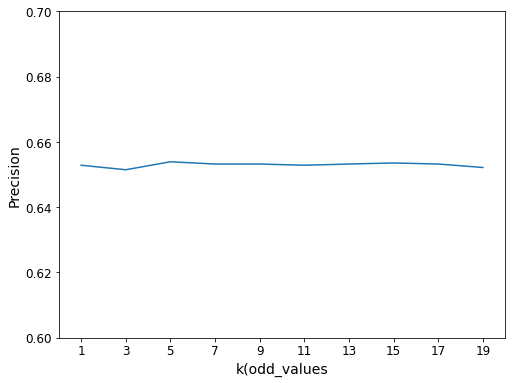

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(1,20,2), precision)
plt.xlim((0,20))
plt.ylim((0.6, 0.7))
plt.xlabel('k(odd_values')
plt.ylabel('Precision')
plt.xticks(ticks=np.arange(1,20,2), labels=np.arange(1,20,2))
plt.show()

## Going without PCA  

* Let us use KNN classifier with all the features in the training samples. Hoping that it increases the performance of the model (ofcourse at the cost of computation).  
* Let's search for K by using cross validation.  
* Note: It takes about 20 mins for entire computation.  

In [ ]:
pipe_knn = make_pipeline(MinMaxScaler(),
                            KNeighborsClassifier(n_neighbors=1))

In [ ]:
grid_k = {'KNeighborsClassifier__n_neighbors':[1,3,5,7,9,11]}
cv = GridSearchCV(pipe_knn, param_grid=grid_k,scoring='precision', cv=5)
cv.fit(x_train, y_train_0)
print(cv)

In [ ]:
print(cv.cv_results_)

* The best value of k is 7

In [ ]:
# we update pipe_knn pipeline
pipe_knn = make_pipeline(MinMaxScaler(),
                            KNeighborsClassifier(n_neighbors=7))

## Performance on test set  

In [ ]:
y_hat_0 = pipe_knn.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_0)
plt.show()

## Multiclass classification  

* Extending KNN classifier to multiclass problem is quite straightforward.  

In [ ]:
print(pipe_knn)

In [ ]:
pipe_knn.fit(x_train, y_train)
y_hat = pipe_knn.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat)
plt.show()

In [ ]:
pipe_knn.classes_

In [ ]:
print(classification_report(y_test, y_hat))